In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab 
import scipy.stats as stats
import math

In [13]:
# 导入数据
def load_data():
    data = pd.read_excel('../data/only-score.xlsx')
    data.drop(['Unnamed: 0'], axis=1, inplace=True)
    print("Load success!\nShape of matrix:", data.shape)
    return data

In [18]:
# 根据缺失数据位置进行切片，得到无缺失的评分矩阵
def drop_all_na(df):
    if not isinstance(df, pd.DataFrame):
        print("ERROR: Not DF.")
        return df
    ret_df = df.copy()
    ret_df.dropna(axis=1, how="all", inplace=True)
    ret_df.dropna(axis=0, how="any", inplace=True)
    print("Drop all 'nan' in matrix.")
    return ret_df

In [4]:
# 丢弃完全缺失的数据，得到部分缺失的评分矩阵
def drop_partail_na(df):
    if not isinstance(df, pd.DataFrame):
        print("ERROR: Not DF.")
        return df
    ret_df = df.copy()
    ret_df.dropna(axis=1, how="all", inplace=True)
    ret_df.dropna(axis=0, how="all", inplace=True)
    return ret_df

In [5]:
# 打印评分Series的柱状图
def print_bar(data):
    plt.figure()
    plt.bar(data.index, data)
    plt.show()
    return
def print_dup_bar(data1, data2):
#     plt.figure()
#     plt.barh(data1.index, data1)
#     plt.barh(data1.index, -data2)
    total_width, n = 0.8, 2
    width = total_width / n
    plt.bar(data1.index, data1,  width=width)
    plt.bar(data1.index + width, data2, width=width)
    
    plt.show()

In [6]:
# 按行/列标准化数据
def normalize_score(data, axis=0):
    if isinstance(data, pd.DataFrame):
        mean = data.mean(axis=1-axis)
        std = data.std(axis=1-axis)
        data = data.sub(mean, axis=axis).div(std, axis=axis)
    elif isinstance(data, pd.Series):
        mean = data.mean(axis=1-axis)
        std = data.std(axis=1-axis)
        data = data.sub(mean, axis=axis).div(std, axis=axis)
    return data

In [50]:
# 使用减小评分人评分标准差距的策略
def get_score_by_norm(score_df_origin):
    
    # 丢弃所有空数据
    score_df_lite = drop_all_na(score_df_origin)
    
    # 计算源数据的数值特征
    score_mean_origin = score_df_lite.mean(axis=0)
    
    # 标准化源数据
    score_df_lite_norm = normalize_score(score_df_lite, axis=0)
    
    # 计算最后得分
    score_final = score_df_lite_norm.mean(axis=0).mul(score_mean_origin.std()).add(score_mean_origin.mean())
    
    return score_mean_origin.round(decimals=2), score_final.round(decimals=2), score_df_lite_norm

In [43]:
# 比较处理前后分数
def evaluate(before, after):
    
    # 输出柱状图
    print_dup_bar(before, after)
    
    # 输出表格
    print("Comparing score:")
    print(pd.DataFrame({"Before":before, "After":after}))
    print("/----------------------------------------------------/")
    # 输出排名变化情况
    print("Comparing rank:")
    print(pd.DataFrame({"Before":before.rank(ascending=False, method='min').astype('int'), 
                        "After":after.rank(ascending=False, method='min').astype('int')}))

In [88]:
# 检查是否对自己评分出现误差
def check_selfish(data):
    self_score = pd.Series(data=data.columns.isin(data.index), index=data.columns)
    for column in data.columns:
        if not self_score[column]:
            continue
        mean = data.loc[:,column].drop(column).mean()
        std = data.loc[:,column].drop(column).std()
        conf_intveral = stats.norm.interval(0.9, loc=mean, scale=std)
        if data.at[column, column] > conf_intveral[1]:
            print(column, "is selfish.")
        elif data.at[column, column] < conf_intveral[0]:
            print(column, "is lack of confidence.")

Load success!
Shape of matrix: (31, 27)
Drop all 'nan' in matrix.


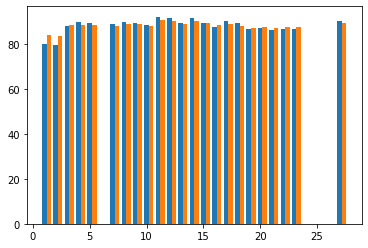

Comparing score:
    Before  After
1    79.71  83.69
2    79.59  83.56
3    87.76  88.46
4    89.71  88.36
5    89.41  88.51
7    88.65  88.04
8    89.47  88.69
9    89.06  88.85
10   88.47  88.01
11   92.00  90.70
12   91.53  90.04
13   89.29  88.69
14   91.59  90.25
15   89.24  89.27
16   87.59  88.34
17   89.88  88.62
18   89.12  87.77
19   86.76  86.86
20   86.88  87.52
21   86.29  87.19
22   86.76  87.47
23   86.76  87.22
27   89.94  89.35
/----------------------------------------------------/
Comparing rank:
    Before  After
1       22     22
2       23     23
3       15     11
4        6     12
5        8     10
7       13     14
8        7      7
9       12      6
10      14     15
11       1      1
12       3      3
13       9      7
14       2      2
15      10      5
16      16     13
17       5      9
18      11     16
19      18     21
20      17     17
21      21     20
22      18     18
23      18     19
27       4      4


In [71]:
score_df = load_data()
score_origin, score_final, score_norm = get_score_by_norm(score_df)
evaluate(score_origin, score_final)

In [89]:
check_selfish(score_norm)

2 is selfish.
9 is selfish.
17 is selfish.
21 is selfish.
22 is selfish.


In [53]:
score_df_lite

,1,2,3,4,5,7,8,9,10,11,...,15,16,17,18,19,20,21,22,23,27
2,85.0,85.0,90.0,82.0,90.0,85.0,89.0,83.0,85.0,89.0,...,90.0,90.0,83.0,81.0,82.0,80.0,80.0,80.0,80.0,86.0
3,80.0,80.0,85.0,100.0,90.0,90.0,90.0,88.0,90.0,90.0,...,85.0,85.0,100.0,100.0,100.0,87.0,87.0,87.0,87.0,88.0
6,87.0,85.0,84.0,89.0,87.0,87.0,92.0,91.0,90.0,95.0,...,87.0,86.0,90.0,91.0,89.0,91.0,89.0,93.0,89.0,93.0
7,75.0,75.0,90.0,90.0,95.0,90.0,90.0,90.0,90.0,93.0,...,90.0,90.0,90.0,90.0,90.0,85.0,85.0,85.0,85.0,90.0
9,88.0,88.0,90.0,91.0,88.0,90.0,90.0,92.0,90.0,91.0,...,90.0,90.0,90.0,88.0,88.0,90.0,90.0,90.0,89.0,90.0
10,85.0,85.0,95.0,92.0,90.0,95.0,97.0,90.0,93.0,99.0,...,96.0,90.0,90.0,91.0,80.0,93.0,90.0,92.0,91.0,92.0
11,60.0,60.0,75.0,86.0,85.0,90.0,88.0,85.0,85.0,95.0,...,83.0,75.0,81.0,80.0,60.0,79.0,75.0,79.0,77.0,91.0
12,85.0,85.0,86.0,85.0,90.0,88.0,87.0,88.0,87.0,90.0,...,87.0,85.0,87.0,85.0,86.0,86.0,86.0,85.0,86.0,90.0
13,65.0,65.0,80.0,75.0,85.0,80.0,85.0,89.0,82.0,92.0,...,85.0,80.0,80.0,78.0,65.0,77.0,73.0,75.0,82.0,87.0
15,65.0,65.0,80.0,85.0,90.0,85.0,85.0,85.0,85.0,90.0,...,85.0,80.0,85.0,80.0,85.0,80.0,80.0,80.0,80.0,85.0


In [155]:
score_df_lite.mean(axis=1)

2     85.043478
3     89.434783
6     89.521739
7     88.521739
9     89.739130
10    92.130435
11    81.304348
12    87.000000
13    80.434783
15    82.608696
16    88.304348
17    89.652174
18    88.434783
19    91.304348
20    90.043478
21    92.000000
22    91.608696
dtype: float64

In [95]:
value_counts = {}
for index in score_df_lite.index:
    value_counts.update({index:score_df_lite.loc[index].value_counts()})
score_counts = pd.DataFrame(value_counts).fillna(0)

In [10]:
_score_df_lite = score_df_lite.apply(lambda series : series.apply(lambda x : math.tan((x - 50.0) / 100.0)*math.pi))
_score_df_lite

,1,2,3,4,5,7,8,9,10,11,...,15,16,17,18,19,20,21,22,23,27
2,1.146771,1.146771,1.328244,1.041091,1.328244,1.146771,1.291367,1.076074,1.146771,1.291367,...,1.328244,1.328244,1.076074,1.006339,1.041091,0.971808,0.971808,0.971808,0.971808,1.182504
3,0.971808,0.971808,1.146771,1.716260,1.328244,1.328244,1.328244,1.254792,1.328244,1.328244,...,1.146771,1.146771,1.716260,1.716260,1.716260,1.218508,1.218508,1.218508,1.218508,1.254792
6,1.218508,1.146771,1.111297,1.291367,1.218508,1.218508,1.402949,1.365434,1.328244,1.517562,...,1.218508,1.182504,1.328244,1.365434,1.291367,1.365434,1.291367,1.440800,1.291367,1.440800
7,0.802180,0.802180,1.328244,1.328244,1.517562,1.328244,1.328244,1.328244,1.328244,1.440800,...,1.328244,1.328244,1.328244,1.328244,1.328244,1.146771,1.146771,1.146771,1.146771,1.328244
9,1.254792,1.254792,1.328244,1.365434,1.254792,1.328244,1.328244,1.402949,1.328244,1.365434,...,1.328244,1.328244,1.328244,1.254792,1.254792,1.328244,1.328244,1.328244,1.291367,1.328244
10,1.146771,1.146771,1.517562,1.402949,1.328244,1.517562,1.595822,1.328244,1.440800,1.675688,...,1.556498,1.328244,1.328244,1.365434,0.971808,1.440800,1.328244,1.402949,1.365434,1.402949
11,0.315211,0.315211,0.802180,1.182504,1.146771,1.328244,1.254792,1.146771,1.146771,1.517562,...,1.076074,0.802180,1.006339,0.971808,0.315211,0.937491,0.802180,0.937491,0.869461,1.365434
12,1.146771,1.146771,1.182504,1.146771,1.328244,1.254792,1.218508,1.254792,1.218508,1.328244,...,1.218508,1.146771,1.218508,1.146771,1.182504,1.182504,1.182504,1.146771,1.182504,1.328244
13,0.474805,0.474805,0.971808,0.802180,1.146771,0.971808,1.146771,1.291367,1.041091,1.402949,...,1.146771,0.971808,0.971808,0.903379,0.474805,0.869461,0.735583,0.802180,1.041091,1.218508
15,0.474805,0.474805,0.971808,1.146771,1.328244,1.146771,1.146771,1.146771,1.146771,1.328244,...,1.146771,0.971808,1.146771,0.971808,1.146771,0.971808,0.971808,0.971808,0.971808,1.146771


In [11]:
s_2 = _score_df_lite.loc[2]
s_2_mean = s_2.mean()
s_2_sigma = s_2.std()
s_2

1     1.146771
2     1.146771
3     1.328244
4     1.041091
5     1.328244
7     1.146771
8     1.291367
9     1.076074
10    1.146771
11    1.291367
12    1.254792
13    1.076074
14    1.328244
15    1.328244
16    1.328244
17    1.076074
18    1.006339
19    1.041091
20    0.971808
21    0.971808
22    0.971808
23    0.971808
27    1.182504
Name: 2, dtype: float64

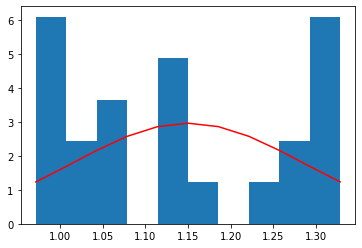

In [22]:
num_bins = 10
n, bins, patches = plt.hist(s_2, num_bins, density=1) 
y_True = sta.norm.pdf(bins, s_2_mean, s_2_sigma)
plt.plot(bins, y_True, color='r', label='True')

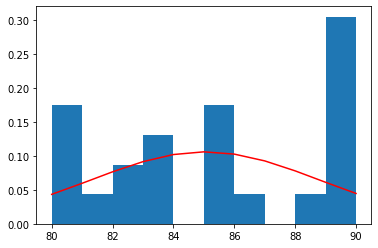

In [13]:
num_bins = 10
n, bins, patches = plt.hist(score_df_lite.loc[2], num_bins, density=1) 
y_True = sta.norm.pdf(bins, score_df_lite.loc[2].mean(), score_df_lite.loc[2].std())
plt.plot(bins, y_True, color='r', label='True')

In [14]:
score_df_lite.loc[2]

1     85.0
2     85.0
3     90.0
4     82.0
5     90.0
7     85.0
8     89.0
9     83.0
10    85.0
11    89.0
12    88.0
13    83.0
14    90.0
15    90.0
16    90.0
17    83.0
18    81.0
19    82.0
20    80.0
21    80.0
22    80.0
23    80.0
27    86.0
Name: 2, dtype: float64

In [60]:
df = pd.DataFrame(np.arange(12).reshape(3, 4),
...                   columns=[0, 1, 2, 3])

In [61]:
df

,0,1,2,3
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11


In [62]:
df.apply(axis=0, func=lambda serie: serie.drop().sum())

0    0
1    0
2    0
3    0
dtype: int64

In [65]:
df.loc[:, 0]

0    0
1    4
2    8
Name: 0, dtype: int32